Entregable N° 1 Horn Martín

### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

### Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

In [2]:

import numpy as np
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.datasets import fetch_20newsgroups

# cargamos los datos (ya separados en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

X_train_texts = newsgroups_train.data  # textos de entrenamiento
y_train = newsgroups_train.target      # etiquetas de entrenamiento
X_test_texts = newsgroups_test.data    # textos de test
y_test = newsgroups_test.target        # etiquetas de test

print(f"Total documentos de entrenamiento: {len(X_train_texts)}")
print(f"Total documentos de test: {len(X_test_texts)}")


tfidfvect = TfidfVectorizer(max_features=5000,  # para minimizar la memoria a utilizar al entrenar
                min_df=5,          # ignora terminos muy raros
                max_df=0.5,        # ignora terminos muy frecuentes
                )
X_train = tfidfvect.fit_transform(X_train_texts)
X_test = tfidfvect.transform(X_test_texts)

print("\n=== Info de la matriz TF-IDF (train) ===")
print(f"Shape: {X_train.shape} (n_docs, n_terms)")
print(f"Número de documentos: {X_train.shape[0]}")
print(f"Tamaño del vocabulario: {X_train.shape[1]}")


print("\n=== Similitud de documentos (5 ejemplos) ===")
random_docs_indices = random.sample(range(X_train.shape[0]), 5)

for doc_idx in random_docs_indices:
    # similaridad del documento doc_idx contra TODOS los documentos del set de entrenamiento
    sim_vector = cosine_similarity(X_train[doc_idx], X_train).flatten()
    
    # ordenamos índices de mayor a menor similitud
    sorted_indices = np.argsort(sim_vector)[::-1]
    
    # tomamos los 5 más similares (evitando el documento en sí)
    top_5_similar = [i for i in sorted_indices if i != doc_idx][:5]
    
    print(f"\nDocumento base ( índice={doc_idx}): Clase '{newsgroups_train.target_names[y_train[doc_idx]]}'")
    print("Texto ( primeras 200 letras):")
    print(X_train_texts[doc_idx][:200], "...")
    
    print("Documentos más similares (top 5):")
    for idx_sim in top_5_similar:
        print(f"   - idx={idx_sim}, Similitud={sim_vector[idx_sim]:.4f}, "
              f"Clase='{newsgroups_train.target_names[y_train[idx_sim]]}'")






Total documentos de entrenamiento: 11314
Total documentos de test: 7532

=== Info de la matriz TF-IDF (train) ===
Shape: (11314, 5000) (n_docs, n_terms)
Número de documentos: 11314
Tamaño del vocabulario: 5000

=== Similitud de documentos (5 ejemplos) ===

Documento base ( índice=10575): Clase 'sci.crypt'
Texto ( primeras 200 letras):

I am not an expert in the cryptography science, but some basic things
seem evident to me, things which this Clinton Clipper do not address.
The all pertain to opportunites for abuse, and conclusions  ...
Documentos más similares (top 5):
   - idx=5856, Similitud=0.4874, Clase='sci.crypt'
   - idx=1660, Similitud=0.4772, Clase='sci.crypt'
   - idx=6765, Similitud=0.4651, Clase='sci.crypt'
   - idx=2825, Similitud=0.4619, Clase='sci.crypt'
   - idx=1379, Similitud=0.4472, Clase='sci.crypt'

Documento base ( índice=8883): Clase 'misc.forsale'
Texto ( primeras 200 letras):
Hi,

	I have a Quantum ProDrive LPS 40 MB SCSI hard drive for sale.
	It came with my M

La mayoria de los documentos mas similares pertenecen a la misma clase o a clases “relacionadas” (por ejemplo, varios con talk.politics.* o sci.med). Esto refuerza la idea de que el modelo TF-IDF capta bien ciertos temas comunes en los textos.

En cuanto a los errores del modelo. Es posible que el documento de deporte mencione muchos terminos tecnicos , de esta manera las similitudes podrian estar mas cerca a clases de tipo comp.* o sci.*

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

In [3]:
print("\n=== Búsqueda de mejores parámetros con GridSearchCV (F1-macro) ===")


# definimos un pipeline SOLO con el modelo.
# Para variar alpha y tipo de NB, podemos usar una clase switcher de clasificadores, 
# o hacer 2 GridSearch diferentes. Aca muestro un ejemplo sencillo y directo.

from sklearn.base import BaseEstimator, ClassifierMixin

class ClfSwitcher(BaseEstimator, ClassifierMixin):
    """Para alternar entre distintos clasificadores dentro de un GridSearch."""
    def __init__(self, estimator=MultinomialNB()):
        self.estimator = estimator
    def fit(self, X, y=None):
        self.estimator.fit(X, y)
        return self
    def predict(self, X):
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

pipeline = Pipeline([
    ('clf', ClfSwitcher())
])

param_grid = [
    {
        'clf__estimator': [MultinomialNB(), ComplementNB()],
        'clf__estimator__alpha': [0.01, 0.1, 1.0, 5.0]
    }
]

f1_macro_scorer = make_scorer(f1_score, average='macro')

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=f1_macro_scorer,
    cv=3,   # cross-validation
    verbose=1,
    n_jobs=-1
)

# ajustamos con X_train (que ya es la matriz TF-IDF) y y_train
grid.fit(X_train, y_train)

print("\nMejores parámetros:", grid.best_params_)
print("Mejor F1-score ( validacion cruzada):", grid.best_score_)

# Predecimos sobre el test
y_pred = grid.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='macro')
print("F1-score en test:", test_f1)



=== Búsqueda de mejores parámetros con GridSearchCV (F1-macro) ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Mejores parámetros: {'clf__estimator': MultinomialNB(), 'clf__estimator__alpha': 0.01}
Mejor F1-score ( validacion cruzada): nan
F1-score en test: 0.6253558089944357


c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


En primer lugar, se identificó que el mejor clasificador según la busqueda fue MultinomialNB con alpha=0.01 obteniendo, ademas,  un F1 macro de 0.625 lo cual resulta en un resultado aceptable. Como punto de mejora, se menciona que sería posible cambiar max_features, min_df, max_df o agregar algun preprocesamiento adicional para obtener mejores resultados.

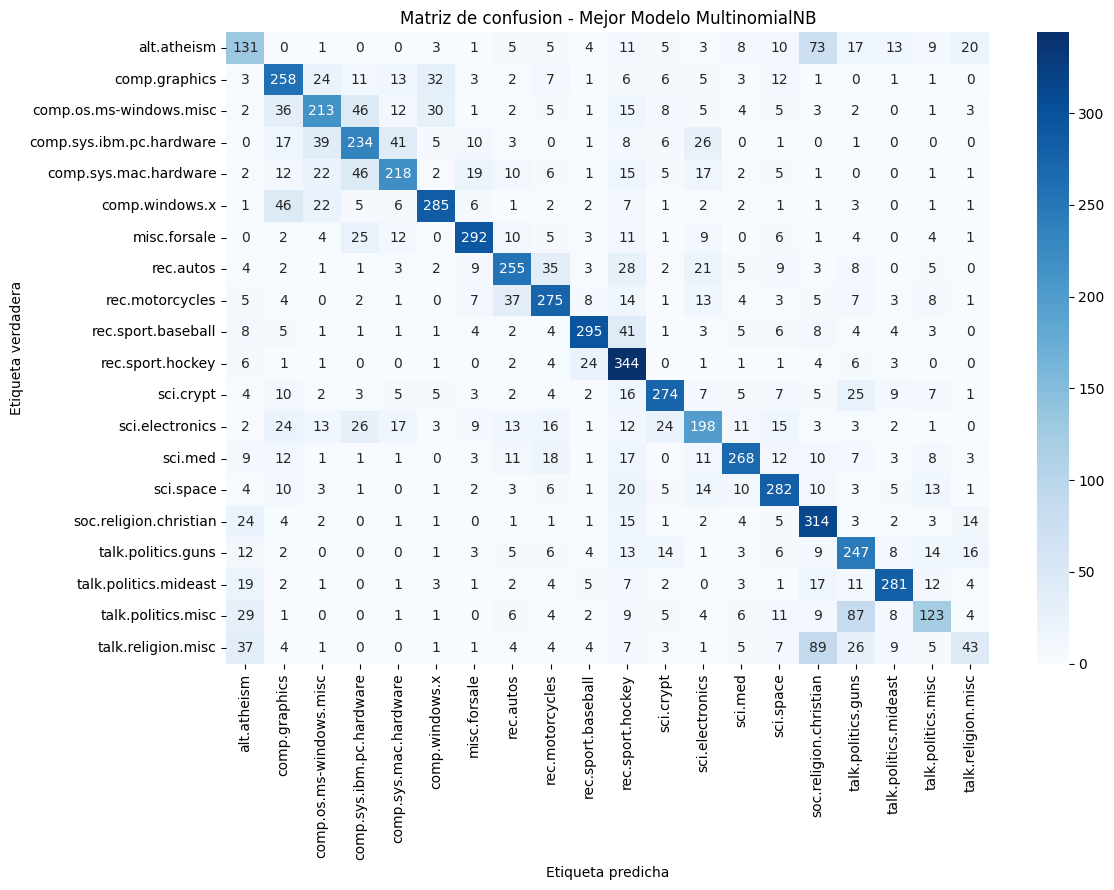

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# obtenemos las predicciones del mejor modelo
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(12, 9))

sns.heatmap(
    cm, 
    annot=True,       
    cmap="Blues",     
    fmt="d",          
    xticklabels=newsgroups_train.target_names, 
    yticklabels=newsgroups_train.target_names
)

plt.title("Matriz de confusion - Mejor Modelo MultinomialNB")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta verdadera")
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.tight_layout()       
plt.show()

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.

In [3]:

print("\n=== Similitud de palabras ===")
# obtenemos la matriz término-documento transponiendo X_train
X_train_tfidf_transposed = X_train.T  # shape: (n_terms, n_docs)

# Calculamos la similitud coseno de cada término con cada término
word_word_similarity = cosine_similarity(X_train_tfidf_transposed)
print(f"Shape matriz de similitud palabra-palabra: {word_word_similarity.shape}")


=== Similitud de palabras ===
Shape matriz de similitud palabra-palabra: (5000, 5000)


In [ ]:

# Obtenemos el vocabulario y la lista de términos en orden
feature_names = tfidfvect.get_feature_names_out()

In [5]:
feature_names.size

5000

In [6]:
feature_names[4500:5000]

array(['thinking', 'thinks', 'third', 'this', 'thomas', 'those', 'thou',
       'though', 'thought', 'thoughts', 'thousand', 'thousands', 'thread',
       'threat', 'threatened', 'three', 'threw', 'through', 'throughout',
       'throw', 'throwing', 'thrown', 'thru', 'thursday', 'thus', 'ti',
       'ticket', 'tickets', 'tie', 'tied', 'tiff', 'till', 'tim', 'time',
       'timer', 'times', 'timing', 'tiny', 'tire', 'tired', 'tires',
       'titan', 'title', 'tl', 'tm', 'tn', 'tobacco', 'today', 'together',
       'told', 'tom', 'tommy', 'tomorrow', 'tonight', 'tony', 'too',
       'took', 'tool', 'toolkit', 'tools', 'top', 'topic', 'topics',
       'tor', 'toronto', 'total', 'totally', 'touch', 'tough', 'toward',
       'towards', 'tower', 'town', 'toyota', 'tq', 'trace', 'track',
       'tracking', 'trade', 'traded', 'tradition', 'traditional',
       'traffic', 'tragedy', 'train', 'training', 'transfer',
       'translation', 'transmission', 'transmitted', 'travel', 'treat',
       '

In [7]:
# seleccionamos 5 palabras 
chosen_words = ["toyotransferta", "vehicle", "weekly", "zealand", "woman"]

for w in chosen_words:
    # buscamos el indice en el vocabulario

    indices = np.where(feature_names == w)[0]
    if len(indices) > 0:
        w_idx = indices[0]
        sim_vector = word_word_similarity[w_idx]  # similitud con la palabra w
        # ordenamos de mayor a menor
        sorted_indices = np.argsort(sim_vector)[::-1]
        
        # tomamos los 5 mas similares (evitando la palabra en si)
        top_5_similar = [i for i in sorted_indices if i != w_idx][:5]
        
        print(f"\nPalabra base: '{w}' (idx={w_idx})")
        for idx_sim in top_5_similar:
            print(f"   - {feature_names[idx_sim]}: similitud={sim_vector[idx_sim]:.4f}")
    else:
        print(f"\nLa palabra '{w}' no está en el vocabulario.")


La palabra 'toyotransferta' no está en el vocabulario.

Palabra base: 'vehicle' (idx=4732)
   - delta: similitud=0.1313
   - dc: similitud=0.1122
   - 408: similitud=0.1117
   - mileage: similitud=0.1051
   - vehicles: similitud=0.0995

Palabra base: 'weekly' (idx=4843)
   - brian: similitud=0.1408
   - baseball: similitud=0.1306
   - throughout: similitud=0.1302
   - central: similitud=0.1177
   - week: similitud=0.1104

Palabra base: 'zealand' (idx=4995)
   - separately: similitud=0.2199
   - complaints: similitud=0.2032
   - eg: similitud=0.1670
   - syndrome: similitud=0.1493
   - treated: similitud=0.1411

Palabra base: 'woman' (idx=4912)
   - her: similitud=0.1763
   - women: similitud=0.1758
   - husband: similitud=0.1644
   - men: similitud=0.1589
   - she: similitud=0.1302


Para vehicle, las palabras más similares no siempre son las más intuitivas (“delta”, “dc”, “408”, “mileage”), puede que las mismas esten relacionadas a modelos de autos (408 ) o delta vehicles systems que es un sistema que aparentemente se utiliza en EEUU.  En cuanto a woman se observan mas claramente términos como “her”, “women”, “husband”, “men”, que si tienen un contexto semantico cercano.

De todas formas, la similitud puede verse afectada por el peso inverso de frecuencia de los terminos. Palabras muy frecuentes en pocas categorías o muy especificas podrian estar ocasionando mayor similitud con otros terminos que coocurren en esos mismos documentos.